# Logistic and linear regression with deterministic and stochastic first order methods

   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[0. Test Numba](#numba)<br>
[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [ ]:
%matplotlib inline

In [ ]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
import numba # available at: http://numba.pydata.org/numba-doc/latest/user/installing.html
from numba import njit

In [ ]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='numba'></a>
## 0. Make sure Numba is correctly installed
Instructions available at: http://numba.pydata.org/numba-doc/latest/user/installing.html

In [ ]:
print(numba.__version__) # Your version of Numba

0.48.0


In [ ]:
@njit
def go_fast(a): # Function is compiled to machine code when called the first time
    trace = 0
    # assuming square input matrix
    for i in range(a.shape[0]):   # Numba likes loops
        trace += np.tanh(a[i, i]) # Numba likes NumPy functions
    return a + trace              # Numba likes NumPy broadcasting

x = np.arange(100).reshape(10, 10)
go_fast(x); # Running a first time the function to compile it

Iteration time of the Numba-compiled function.

In [ ]:
%timeit go_fast(x)

The slowest run took 25.36 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 985 ns per loop


Numba-compiled function have a special `.py_func` attribute which is the original uncompiled Python function.  Iteration time of the uncompiled function should be greater.

In [ ]:
%timeit go_fast.py_func(x)

The slowest run took 5.65 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 23.1 µs per loop


<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [ ]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [ ]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [ ]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [ ]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [ ]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


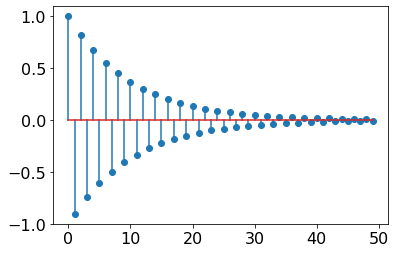

In [ ]:
plt.stem(x_model_truth);

### Numerically check loss and gradient

In [ ]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.3)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

1.8122680721588411e-06

In [ ]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.3)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.4721999831633164e-07

### Choice of the model

In [ ]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.3)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [ ]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.5265014054638006


### Get a very precise minimum to compute distances to minimum

In [ ]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.529597499042454
5.513734808018785e-09


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [ ]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [ ]:
# Number of full batch iterations
n_iter = 100

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)


In [ ]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        x -= step * grad(x, *args)
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step = 1 / lipschitz_linreg(A, b, lbda) # to be set to theoretical step size
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

In [ ]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        if i % store_every == 0:
            x_list.append(x.copy())
        x = y - step * grad(y, *args)
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        y = x + (t - 1) * (x - x_list[-1]) / t_new
        t = t_new
    return x, x_list

In [ ]:
step = 1 / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [ ]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [ ]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [ ]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

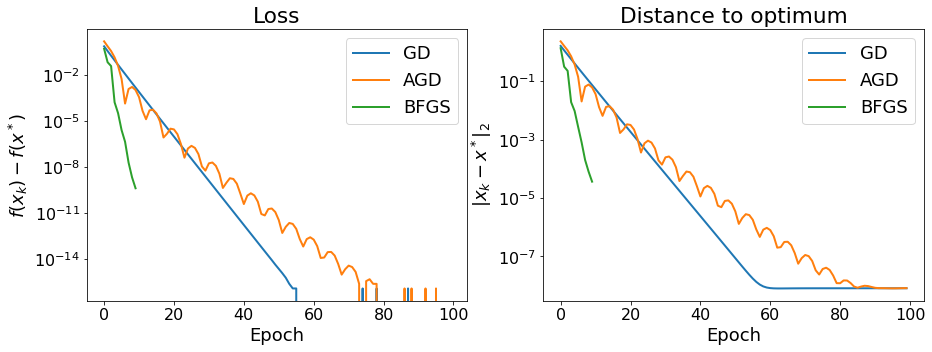

In [ ]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs]

solvers = ["GD", "AGD", "BFGS"]

plot_epochs(monitors, solvers)

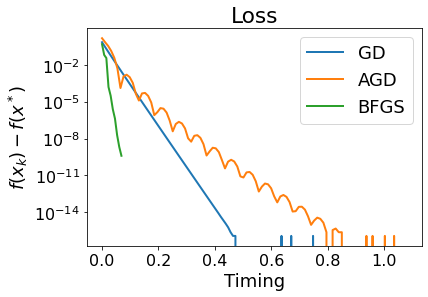

In [ ]:
plot_time(monitors, solvers)

### First conclusions


Regarding the previous graphs one can give some first conclusions :
- GD : It is the slowest algorithm, the convergence is in $O(\dfrac{1}{t})$ so we can observe the linear decrease in the log-scale
- AGD : It is quite faster at the beginning than the GD because of the convergence in $O(\dfrac{1}{t^2})$. 
- BFGS : It is the fastest algorithm, its decrease is linear in the log-scale so the convergence is in $O(\dfrac{1}{t^k})$ with a high $k$. However, it seems to stop quite fast because the sequence is of length 11 instead of 100 for the GD and AGD.



One can see that at each iteration we get closer to the minimum for the GD and BFGS algorithms which is not the case for the AGD algorithm. Instead of a linear decrease in log-scale with can observe bumps. It is not surprising regarding the first lab, it is due to the fact that it is not a classic gradient descent method thanks to the $y$ and $t$.

<a id='stoc'></a> 
## 4. Stochastic methods



For stochastic methods the number of epochs is equal to $n * n\_iter$ because we only compute the gradient for one $f_i$ instead of $\sum_{i=1}^{n}{f_i}$ at each iteration.

In [ ]:
n_epoch = 100 # number of epochs

# generate indices of random samples
iis = np.random.randint(0, n, n*n_iter) # to have the same number of epochs as for GD

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

In [ ]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
      
        x -= step * grad_i(i, x, *args) / np.sqrt(idx+1)
      
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, 
                n*n_iter, 
                step0, args=(A, b, lbda)) # same as in the cell after Q4

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

In [ ]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((store_every, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        averaged_gradient -= gradient_memory[i, :] / store_every
        gradient_memory[i, :] = grad_i(i, x, *args)
        averaged_gradient += gradient_memory[i, :] / store_every
        x -= step * averaged_gradient

        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [ ]:
step = 1 / (lbda + np.max(np.sum(A ** 2, axis=1))) # to be set to theoretical step size

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, 
                n*n_iter, 
                step, args=(A, b, lbda)) # same as in the cell after Q4

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

In [ ]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_old = x.copy()
    x_list = []
    for idx in range(n_iter):
        
        x_old = x.copy()
        mu = grad(x, *args)

        for t in range(store_every) :
            i = iis[idx * store_every + t]
            x -= step * (grad_i(i, x, *args) - grad_i(i, x_old, *args) + mu)
 
        
        # Update metrics after each iteration.
        x_list.append(x.copy())
        
    return x, x_list

In [ ]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, 
                 n_iter,
                 step, args=(A, b, lbda)) # same as in the cell after Q4

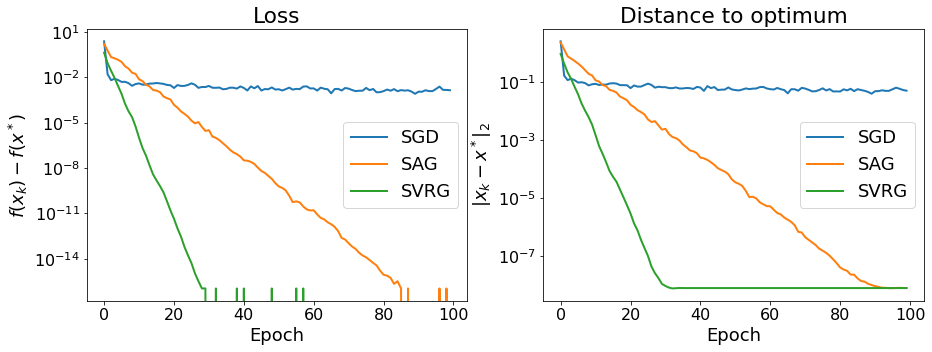

In [ ]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

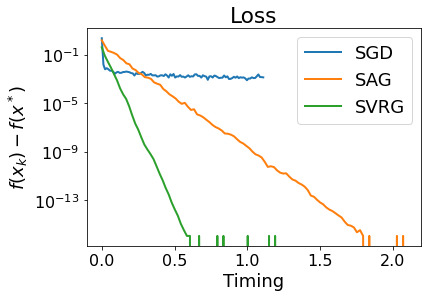

In [ ]:
plot_time(monitors, solvers)

### First conclusions


- SGD : it is the algorithm that starts the faster but is begins to slow down quite fast. As a result, the precision is not very good, it is probably due to the fixed stepsize so we are blocked in terms of precision by the gradient noise.
- SAG : The convergence is linear (in log-scale) with a quite small decrease coefficient compared to SVRG. We don't observe any slow down thanks to the decreasing stepsize but it remains quite slow probably surely because of the matrix of size $n \times d$ it has to store.
- SVRG : It is the fastest algorithm among the 3 stochastic we are given. The decrease is linear in log-scale with a high decrease coefficient.

<a id='comp'></a> 
## 5. Numerical comparison

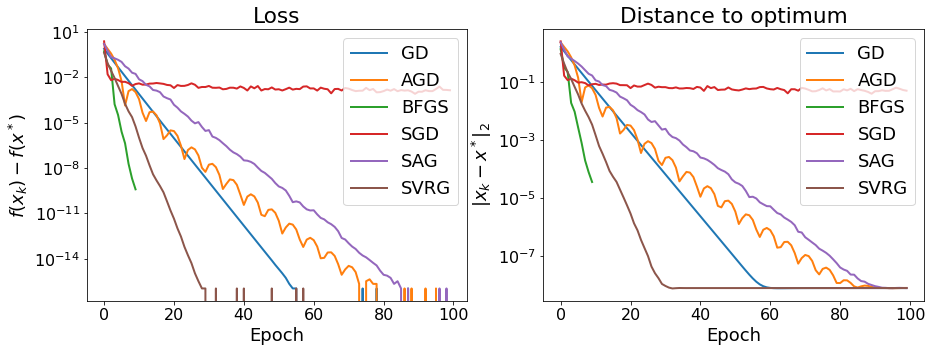

In [ ]:
monitors = [monitor_gd, monitor_agd, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

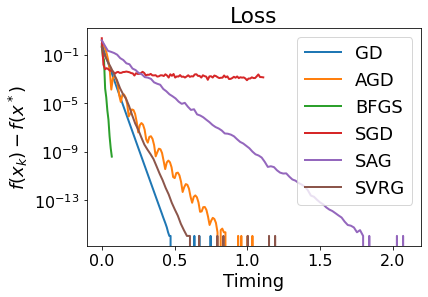

In [ ]:
plot_time(monitors, solvers)


Regarding the previous graphs, one can compare the deterministic and stochastic gradient methods this way :
- SGD and SAG don't seem to perform very well. SGD starts very fast but becomes slow quite rapidly so the linear decrease coefficient (because we are in log-scale) is very small. In addition, one can see that these two algorithms are less stable than deterministic methods because of the many sharps on the curb.
- SVRG can be compared to GD and AGD, it is faster but not that much. These three algorithm reach a very small loss and a high precision in term of distance to the optimum in few epochs. However, BFGS stays way faster than all the algorithms, it is faster in terms of time and more accurate (smaller loss and closer to the minimum).

Regarding the 4 groups of graphs upperhead, one can conclude on the impact of correlation on our algorithms :

*   **Low correlation (=0.3):** The fastest algorithm with such a correlation is BFGS but it stops quite early.

  *   For the linear regression, the deterministic methods are quite fast and accurate while SAG is not accurate and also very slow. SVRG is fast in terms of epochs but not in terms of time (same performance as GD and AGD).
  *   For the logistic regression, stochastic methods are overall better than deterministic methods and SVRG is similar to BFGS in terms of speed but it is even more accurate because it doesn't stop.

*   **High correlation (=0.8):** The fastest algorithm with such a correlation is SVRG. It is accurate and fast in terms of time and epochs. Deterministic methods are not very accurate and quite slow while stochastic methods perform very well. In fact, a high correlation is synonymous with colinear variables so the smallest singular value goes to 0. As a result, the convergence rate for the deterministic methods goes to 1 and the algorithms are slow.



We can infer from what we have seen that stochastic methods are not very good when $d$ is high. 
However, deterministic methods seem to perform the same.

On the opposite, deterministic methods seem to work well when $n$ is lower, meaning that less points to compute leads to better results. Stochastic methods perform the same.

From the previous questions, we can deduce 2 regimes for the correlations, when $corr$ is high and when $corr$ is low : 


*   When it is **low**, **deterministic methods** are much faster than stochastic methods,
*   When it is **high**, deterministic methods, which are still faster than SAG, are not accurate and **stochastic methods** provide **very good** results (except for **SGD**) and **SVRG** is the fastest.

So we need a high correlation to have good optimizer with stochastic methods, especially with SVRG

On the other hand, playing with $\lambda$ yields that **AGD/GD** are very much faster than stochastic methods (except for BFGS) when $\lambda$ is smaller. When $\lambda$ is higher, **AGD/GD** are slightly faster than **SVRG** (but BFGS remains the fastest).



**Different behaviours between deterministic methods**: We can observe that AGD and GD behaves quite the same when tuning the parameters, they follow the same curves, around the same times to complete and roughly the same results.


---
**Different behaviours between stochastic methods**
However, when it comes to stochastic methods, we can always see that SGD performs poorly in terms of results. It perfoms good in time when $\lambda$ is lower, than SAG and SVRG. Now, let's compare SVRG and SAG. It seems that SVRG outperfoms SAG everytime. SAG only performs as SVRG when $\lambda$ is lower.

After having done this lab we can conclude about the memory, the number of hyper parameters to tune and the ease of implementation of each algorithm :

*   **GD:** It's the most basic deterministic algorithm and it is easy to implement. We have to compute one gradient over the entire dataset to update a vector of size $d$ for each of the `n_iter` iterations, which can be quite expensive in terms of memory. We also have to compute a lipschitz constant to tune the stepsize. 
*   **AGD:** It's the accelerated version of the GD algorithm. It's a little bit more complicated to implement because we have to care about 2 vectors of size $d$ that are `x` and `y` and a real `t`. The hyper parameters remain the same.
*   **L-BFGS:** It seems to be far more complicated to implement than the two previous deterministic methods that's why we used the `scipy.optimize` L-BFGS solver. Because the L-BFGS algorithm stores only a few vectors representing an approximation of the Hessian matrix so it is not so expensive in terms of memory. Even if we haven't used lot of them, this algorithm has a lot of hyperparameters.
*   **SGD:** This is the most simple stochastich algorithm, it has a simple implementation. It only has to compute a gradient on one random sample of the dataset at each iteration so it doesn't cost too much memory. In addition, hyperparameters are not very numerous and we don't need to compute any lipschitz constant thanks to the $\eta_0$. However, the loop to update `x` is now $n*n\_iter$ long instead of just $n\_iter$.
*   **SAG:** This algorithm is quite greedy in terms of memory because it has to store a matrix of size $n \times d$. It is not so easy to implement because of the trick to update the sum $G$ in order to decrease the number of iterations. Because we have chosen to use the list `iis` to represent the uniform distribution this algorithm requires quite a lot of parameters, and it also has to select the maximum of the lispchitz constants $L_i$.
*   **SVRG:** In this last algorithm we have nested loops, in the outer loop which is `n_iter` long we have to compute a full gradient which is memory expensive and in the inner loop of length `n` we have to compute 2 gradients on samples. It has a reasonnable number of hyper parameters but it has to compute the maximum of all the lipschitz constants $L_i$ for the stepsize.

According to what we have done before it seems that it is better to use deterministic methods when we have a small correlation and when we use a linear regression. Conversely, high correlation and logistic regression are the conditions for the stochastic methods to deliver the best of themselves. Moreover, the regression type doesn't seem to have a big impact and when the product $n \times d$ is not high the SAG algorithm becomes very fast and accurate.

